In [27]:
from scipy import io
import os
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
%matplotlib inline
import utils_cvPCA

os.chdir('e:\\Python\\molanalysis\\cvPCA')
# dat = io.loadmat('/media/carsen/DATA2/grive/10krecordings/imgResp/natimg2800_M170714_MP032_2017-09-14.mat')
dat = io.loadmat('natimg2800_M170714_MP032_2017-09-14.mat')
# dat = io.loadmat('/cvPCA/natimg2800_M170714_MP032_2017-09-14.mat')

resp = dat['stim'][0]['resp'][0] # stim x neurons
spont = dat['stim'][0]['spont'][0] # timepts x neurons
istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids 
istim -= 1 # get out of MATLAB convention
istim = istim[:,0]
nimg = istim.max() # these are blank stims (exclude them)
resp = resp[istim<nimg, :]
istim = istim[istim<nimg]

# subtract spont (32D)
mu = spont.mean(axis=0)
sd = spont.std(axis=0) + 1e-6
resp = (resp - mu) / sd
spont = (spont - mu) / sd
sv,u = eigsh(spont.T @ spont, k=32)
resp = resp - (resp @ u) @ u.T

# mean center each neuron
resp -= resp.mean(axis=0)

In [28]:
resp.shape
# # spont.shape
# istim.shape
# print(np.unique(istim))
# plt.hist(istim,bins=2800)
# nimg
# os.getcwd()

(6645, 9476)

In [5]:
import pandas as pd
import scipy.stats as st
os.chdir('e:\\Python\\molanalysis\\')
from loaddata.session_info import filter_sessions,load_sessions
from utils.plotting_style import * #get all the fixed color schemes

from utils.imagelib import load_natural_images #
from utils.corr_lib import mean_resp_image

#################################################
# session_list        = np.array([['LPE09665','2023_03_15']])
session_list        = np.array([['LPE11086','2023_12_16']])
sessions,nSessions            = load_sessions(protocol = 'IM',session_list=session_list,load_behaviordata=True, 
                                    load_calciumdata=True, load_videodata=True, calciumversion='deconv')

#%% Load sessions lazy: 
# sessions,nSessions   = load_sessions(protocol = 'IM',session_list=session_list)

#%%   Load proper data and compute average trial responses:                      
for ises in range(nSessions):    # iterate over sessions
    # sessions[ises].load_respmat(load_behaviordata=True, load_calciumdata=True,load_videodata=True,calciumversion='deconv')
    sessions[ises].load_respmat(calciumversion='deconv',keepraw=True)

['IM'] dataset: 1 mice, 1 sessions, 5600 trials
Number of neurons in PM: 903
Number of neurons in V1: 1682
Total number of neurons: 2585


In [23]:
resp = sessions[0].respmat.T
np.shape(resp)
istim = np.array(sessions[0].trialdata['ImageNumber'])
istim
nimg = istim.max() + 1 # these are blank stims (exclude them)
nimg

# mean center each neuron
resp -= resp.mean(axis=0)
resp = resp / (resp.std(axis=0) + 1e-6)


In [29]:
### sanity check - decent signal variance ?
# split stimuli into two repeats
NN = resp.shape[1]
sresp = np.zeros((2, nimg, NN), np.float64)
inan = np.zeros((nimg,)).astype(bool)
for n in range(nimg):
    ist = (istim==n).nonzero()[0]
    i1 = ist[:int(ist.size/2)]
    i2 = ist[int(ist.size/2):]
    # check if two repeats of stim
    if np.logical_or(i2.size < 1, i1.size < 1):
        inan[n] = 1
    else:
        sresp[0, n, :] = resp[i1, :].mean(axis=0)
        sresp[1, n, :] = resp[i2, :].mean(axis=0)
        
# remove image responses without two repeats
sresp = sresp[:,~inan,:]
    
snorm = sresp - sresp.mean(axis=1)[:,np.newaxis,:]
snorm = snorm / (snorm.std(axis=1)[:,np.newaxis,:] + 1e-6)

cc = (snorm[0].T @ snorm[1]) / sresp.shape[1]

print('fraction of signal variance: %2.3f'%np.diag(cc).mean())

fraction of signal variance: 0.165


In [30]:
sresp.shape
cc = sresp[0] @ sresp[1].T
np.shape(cc)

(2800, 2800)

In [31]:
### sanity check - decent decoding ?
# 1 nearest neighbor decoder    
# (mean already subtracted)
cc = sresp[0] @ sresp[1].T
cc /= (sresp[0]**2).sum()
cc /= (sresp[1]**2).sum()
nstims = sresp.shape[1]
print('decoding accuracy: %2.3f'%(cc.argmax(axis=1)==np.arange(0,nstims,1,int)).mean())

decoding accuracy: 0.412


In [34]:
from utils.shuffle_lib import my_shuffle

sresp[0,:,:] = my_shuffle(sresp[0,:,:],method='random')
sresp[1,:,:] = my_shuffle(sresp[1,:,:],method='random')


powerlaw, alpha=0.828


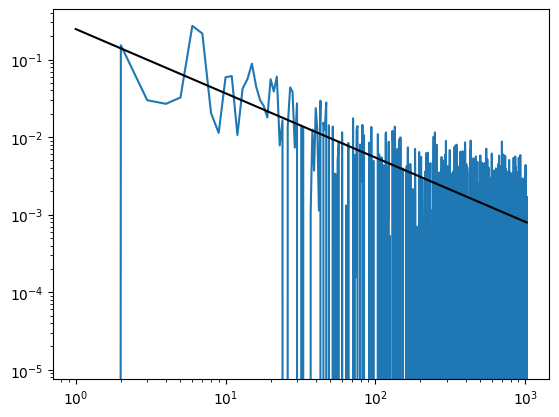

In [35]:
### sanity check - is the powerlaw close to 1 ?
# powerlaw

# compute cvPCA
ss = utils_cvPCA.shuff_cvPCA(sresp)

# compute powerlaw of averaged shuffles
ss = ss.mean(axis=0)
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()
